## Project Summary
This project focuses on leveraging machine learning (ML) models to predict the electronic band gaps of materials, providing a faster and more scalable alternative to density functional theory (DFT) calculations. While DFT is a widely used quantum mechanical method for band gap estimation, it suffers from high computational costs due to iterative self-consistent field (SCF) cycles, k-point sampling, and the use of hybrid functionals, which scale poorly with system size (O(N³ - N⁴) complexity). This makes DFT impractical for large-scale material screening, especially for complex materials with hundreds of atoms. In contrast, ML models trained on existing DFT datasets can rapidly predict band gaps in milliseconds, eliminating the need for solving Schrödinger’s equation for every new material. The goal of this project is to collect semiconductor material data, perform DFT calculations using ORCA, and train deep learning models—such as graph neural networks (GNNs)—to predict material properties. ML models can learn complex patterns in material structures, allowing rapid and scalable predictions with reasonable accuracy. Unlike DFT, which requires solving complex quantum mechanical equations, ML leverages previously computed data to make near-instantaneous predictions, making it a practical solution for large-scale material discovery. In conclusion, this project aims to integrate ML with traditional physics-based methods to create an efficient AI-based approach to semiconductor material selection, reducing production costs and accelerating innovation in the semiconductor industry.

In [ ]:
!pip install pymatgen
!pip uninstall torch-scatter torch-sparse
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric  # if not already installed


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 18.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from pymatgen.core import Composition, Element
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('gs://original_material_data/mp_summary_selected_columns.csv')

In [ ]:
# Display dataset information
print(f"Original Data Shape: {df.shape}")
df.head()

Original Data Shape: (178627, 16)


,Material ID,Formula,Crystal System,Space Group Symbol,Space Group Number,Sites,Energy Above Hull,Formation Energy,Predicted Stable,Volume,Density,Band Gap,Is Gap Direct,Is Metal,Magnetic Ordering,Total Magnetization
0,mp-1094120,Nb,Triclinic,P1,1,12,0.189748,0.189748,False,226.839615,8.161256,0.0000,False,True,NM,0.000120
1,mp-1120447,Si,Triclinic,P1,1,8,0.372510,0.372510,False,163.065268,2.288020,0.0000,False,True,NM,0.000000
2,mp-1179802,Rb,Triclinic,P1,1,8,0.053649,0.053649,False,744.494598,1.525036,0.0000,False,True,NM,0.005090
3,mp-1180008,O2,Triclinic,P1,1,12,0.419854,0.419854,False,199.450062,1.598453,1.2773,False,False,NM,0.000000
4,mp-1180064,O2,Triclinic,P1,1,10,0.387014,0.387014,False,159.269552,1.668092,0.0423,False,False,FM,3.999309


In [ ]:
columns_to_keep = [
    "Formula",
    "Space Group Number",
    "Crystal System",
    "Density",
    "Volume",
    "Sites",
    "Band Gap"  # Target variable
]

df = df[columns_to_keep]

In [ ]:
df

,Formula,Space Group Number,Crystal System,Density,Volume,Sites,Band Gap
0,Nb,1,Triclinic,8.161256,226.839615,12,0.0000
1,Si,1,Triclinic,2.288020,163.065268,8,0.0000
2,Rb,1,Triclinic,1.525036,744.494598,8,0.0000
3,O2,1,Triclinic,1.598453,199.450062,12,1.2773
4,O2,1,Triclinic,1.668092,159.269552,10,0.0423
...,...,...,...,...,...,...,...
178622,ZnP2H11C2NO8,9,Monoclinic,1.942088,1041.311565,100,4.4993
178623,Al2Si2H5C2NO10,9,Monoclinic,2.049555,507.499392,44,0.0000
178624,Fe2H13C6NCl2O11,9,Monoclinic,1.803158,843.114453,70,2.3350
178625,NaMnP2H10NO10,9,Monoclinic,2.357065,456.449640,50,3.9037


## Handling Missing & Duplicated data

In [ ]:
print("\n🔹 (Before) Missing Values:")
print(df.isnull().sum())  # Check missing values

df = df.dropna()  # Drop missing values
df = df.drop_duplicates()  # Remove duplicates

# Afer handling
print("\n🔹 (After) Missing Values:")
print(df.isnull().sum())  # Check missing values



🔹 (Before) Missing Values:
Formula                  3
Space Group Number       0
Crystal System           0
Density                  0
Volume                   0
Sites                    0
Band Gap              8162
dtype: int64

🔹 (After) Missing Values:
Formula               0
Space Group Number    0
Crystal System        0
Density               0
Volume                0
Sites                 0
Band Gap              0
dtype: int64


## Calculating new features

In [ ]:
# Function to compute weighted atomic properties
def get_weighted_atomic_properties(formula):
    """
    Extracts weighted average atomic properties from a given chemical formula.
    """
    try:
        composition = Composition(formula)
        total_atoms = sum(composition.get_el_amt_dict().values())

        weighted_atomic_number = 0
        weighted_electronegativity = 0
        weighted_atomic_radius = 0

        for element, amount in composition.get_el_amt_dict().items():
            elem_obj = Element(element)
            weighted_atomic_number += elem_obj.Z * (amount / total_atoms)
            weighted_electronegativity += (elem_obj.X if elem_obj.X is not None else -1) * (amount / total_atoms)
            weighted_atomic_radius += (elem_obj.atomic_radius if elem_obj.atomic_radius is not None else -1) * (amount / total_atoms)

        return pd.Series({
            "weighted_atomic_number": round(weighted_atomic_number, 3),
            "weighted_electronegativity": round(weighted_electronegativity, 3),
            "weighted_atomic_radius": round(weighted_atomic_radius, 3)
        })

    except Exception as e:
        print(f"Error processing formula {formula}: {e}")
        return pd.Series({"weighted_atomic_number": np.nan, "weighted_electronegativity": np.nan, "weighted_atomic_radius": np.nan})


In [ ]:
# Apply function to extract atomic properties
df_atomic = df["Formula"].apply(get_weighted_atomic_properties)

# Merge extracted properties into the main dataframe
df = pd.concat([df, df_atomic], axis=1)

<ipython-input-8-4afe53f4f1e8>:17: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  weighted_electronegativity += (elem_obj.X if elem_obj.X is not None else -1) * (amount / total_atoms)
<ipython-input-8-4afe53f4f1e8>:17: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  weighted_electronegativity += (elem_obj.X if elem_obj.X is not None else -1) * (amount / total_atoms)
<ipython-input-8-4afe53f4f1e8>:17: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  weighted_electronegativity += (elem_obj.X if elem_obj.X is not None else -1) * (amount / total_atoms)


In [ ]:
df

,Formula,Space Group Number,Crystal System,Density,Volume,Sites,Band Gap,weighted_atomic_number,weighted_electronegativity,weighted_atomic_radius
0,Nb,1,Triclinic,8.161256,226.839615,12,0.0000,41.000,1.600,1.450
1,Si,1,Triclinic,2.288020,163.065268,8,0.0000,14.000,1.900,1.100
2,Rb,1,Triclinic,1.525036,744.494598,8,0.0000,37.000,0.820,2.350
3,O2,1,Triclinic,1.598453,199.450062,12,1.2773,8.000,3.440,0.600
4,O2,1,Triclinic,1.668092,159.269552,10,0.0423,8.000,3.440,0.600
...,...,...,...,...,...,...,...,...,...,...
178622,ZnP2H11C2NO8,9,Monoclinic,1.942088,1041.311565,100,4.4993,6.160,2.636,0.518
178623,Al2Si2H5C2NO10,9,Monoclinic,2.049555,507.499392,44,0.0000,7.182,2.753,0.636
178624,Fe2H13C6NCl2O11,9,Monoclinic,1.803158,843.114453,70,2.3350,6.571,2.707,0.557
178625,NaMnP2H10NO10,9,Monoclinic,2.357065,456.449640,50,3.9037,6.520,2.652,0.574


## Clean up the data with encoding

In [ ]:
# Move "Band Gap" column to the last position
column_order = [col for col in df.columns if col != "Band Gap"] + ["Band Gap"]
df = df[column_order]

df.drop(columns=["Formula"], inplace=True)

# Label Encoding
label_encoder = LabelEncoder()
df["Crystal System"] = label_encoder.fit_transform(df["Crystal System"])

df.head()

<ipython-input-11-4b55c729938b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Formula"], inplace=True)
<ipython-input-11-4b55c729938b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Crystal System"] = label_encoder.fit_transform(df["Crystal System"])


,Space Group Number,Crystal System,Density,Volume,Sites,weighted_atomic_number,weighted_electronegativity,weighted_atomic_radius,Band Gap
0,1,5,8.161256,226.839615,12,41.0,1.60,1.45,0.0000
1,1,5,2.288020,163.065268,8,14.0,1.90,1.10,0.0000
2,1,5,1.525036,744.494598,8,37.0,0.82,2.35,0.0000
3,1,5,1.598453,199.450062,12,8.0,3.44,0.60,1.2773
4,1,5,1.668092,159.269552,10,8.0,3.44,0.60,0.0423


In [ ]:
df.dropna(inplace=True)

<ipython-input-12-c64f9f573c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


## Data Summary

In [ ]:
#Get only numeric columns
numeric_df = df.select_dtypes(include=['number'])

stats = numeric_df.describe()
correlation_matrix = df.corr()

#Calculate the median and standard deviation for numeric columns and correlation matrix
median = numeric_df.median()
std_dev = numeric_df.std()
correlation_matrix = numeric_df.corr()

# Print the results
print(df.info())  # Data types and non-null values
print(f"Basic Statistics:\n{stats}")
print(f"\nMedian:\n{median}")
print(f"\nStandard Deviation:\n{std_dev}")
print(f"\nCorrelation Matrix:\n{correlation_matrix}")

<class 'pandas.core.frame.DataFrame'>
Index: 170359 entries, 0 to 178626
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Space Group Number          170359 non-null  int64  
 1   Crystal System              170359 non-null  int64  
 2   Density                     170359 non-null  float64
 3   Volume                      170359 non-null  float64
 4   Sites                       170359 non-null  int64  
 5   weighted_atomic_number      170359 non-null  float64
 6   weighted_electronegativity  170359 non-null  float64
 7   weighted_atomic_radius      170359 non-null  float64
 8   Band Gap                    170359 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 13.0 MB
None
Basic Statistics:
       Space Group Number  Crystal System        Density         Volume  \
count       170359.000000   170359.000000  170359.000000  170359.000000   
mean            84.890496        

## Visualization

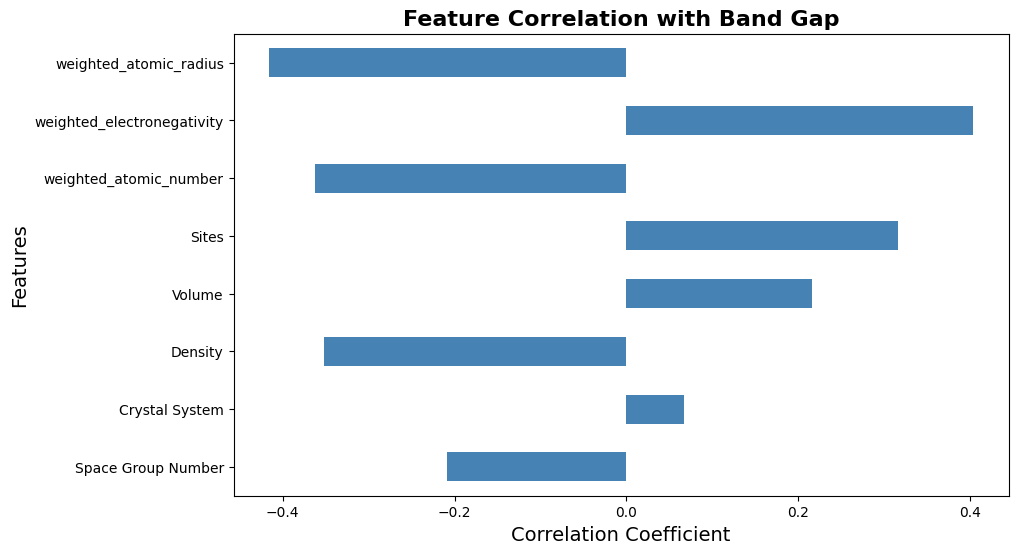

In [ ]:
# Correlation Matrix for Band Gap
correlation_values = df.corr()["Band Gap"].drop(labels="Band Gap")

# Plot correlation values as a horizontal bar chart
plt.figure(figsize=(10, 6))
correlation_values.plot(kind="barh", color="steelblue")

# Add title and labels
plt.title("Feature Correlation with Band Gap", fontsize=16, fontweight="bold")
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Display the plot
plt.show()


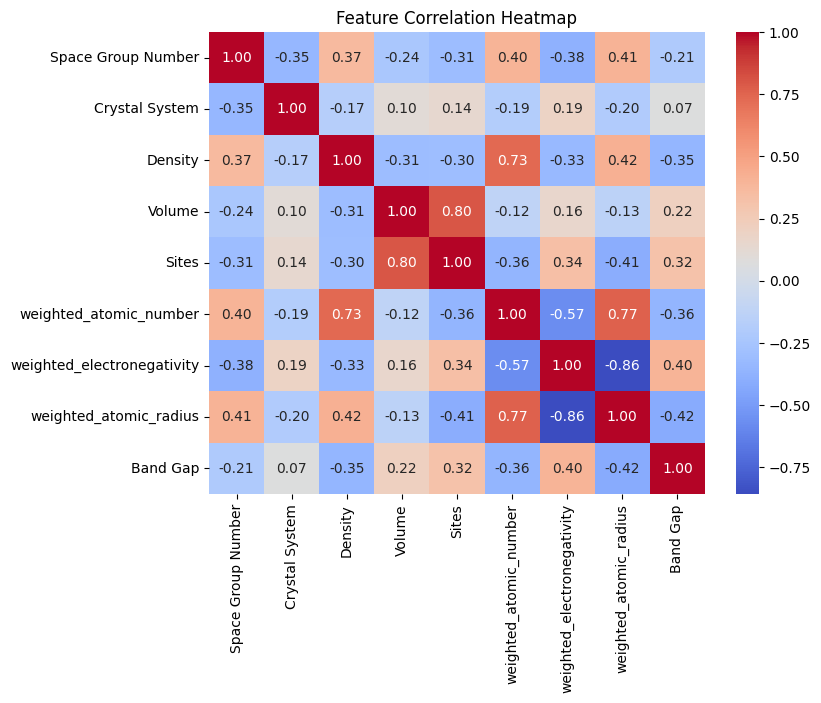

In [ ]:
### Correlation Heatmap ###
plt.figure(figsize=(8,6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

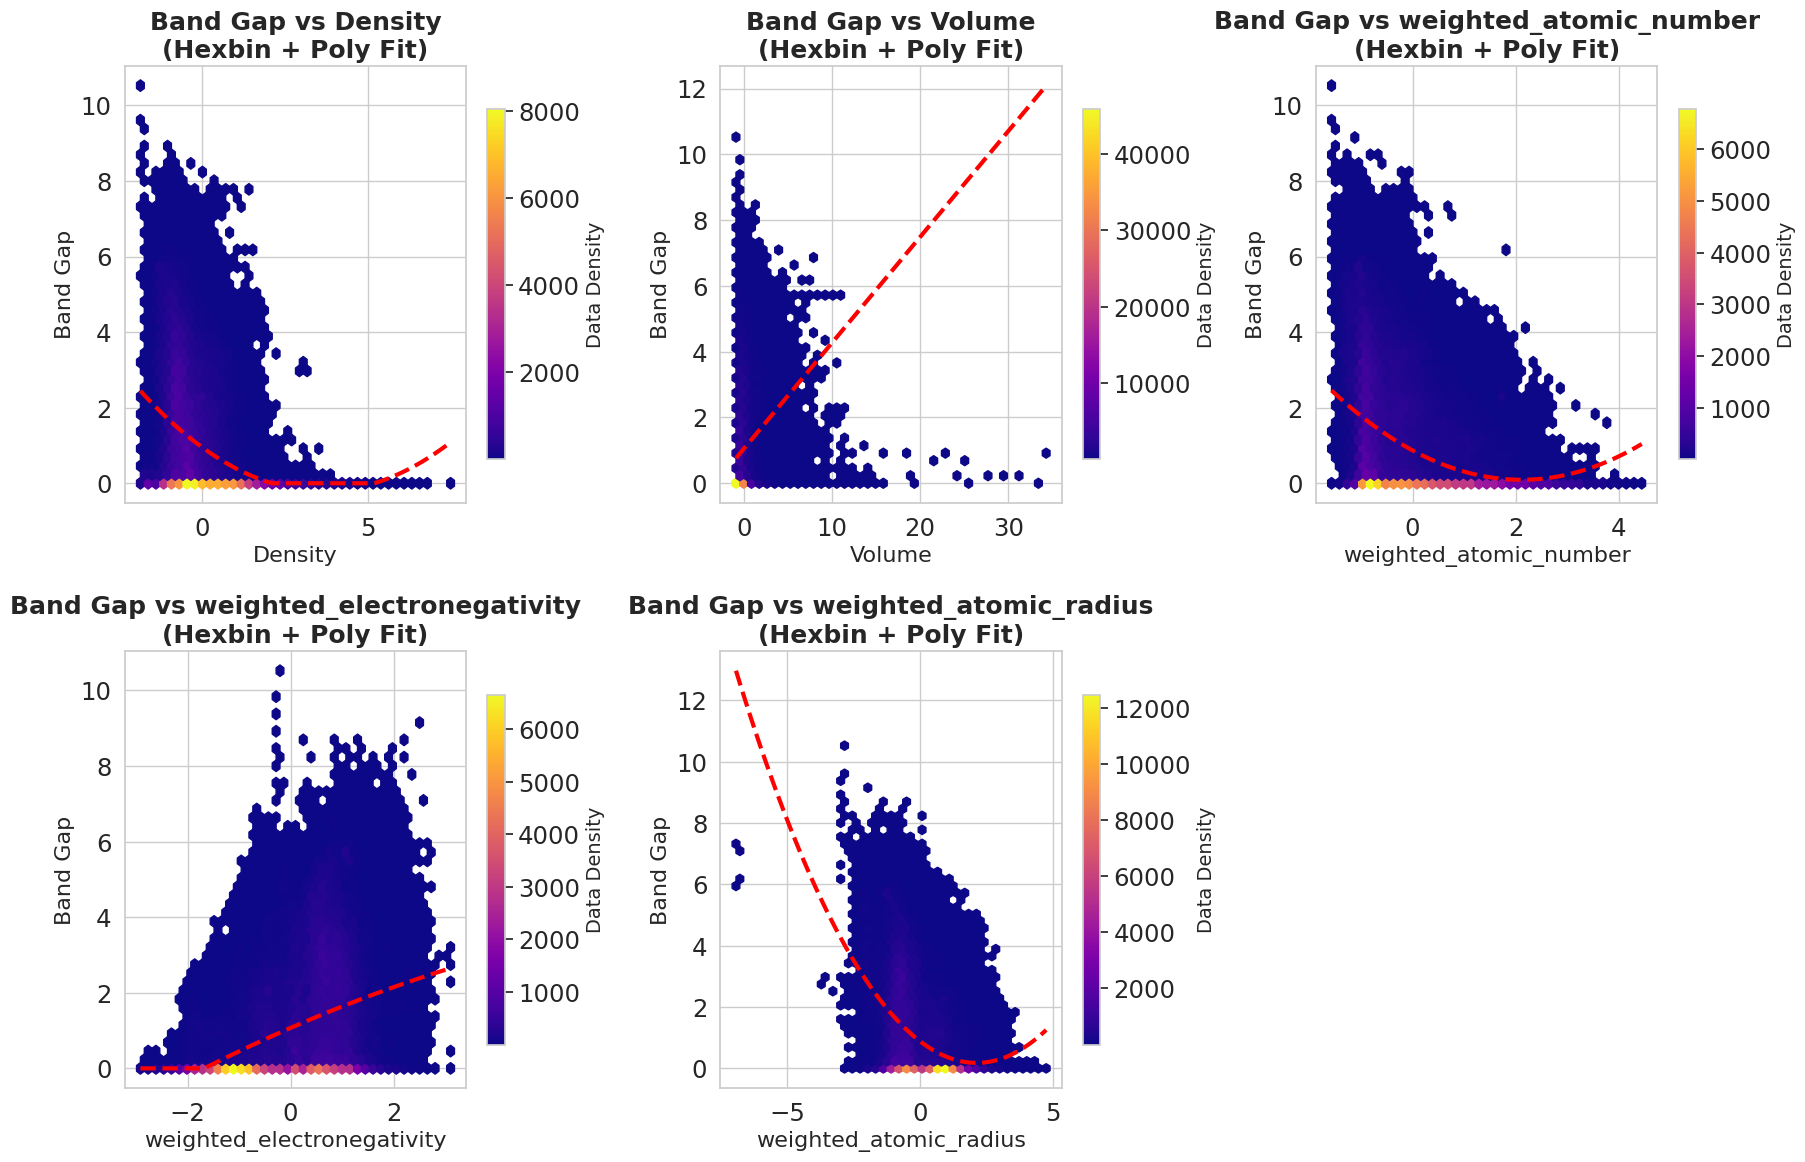

In [ ]:
# Set a modern theme
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)  # Larger fonts for better readability

# Define features to compare with Band Gap
features = ["Density", "Volume", "weighted_atomic_number", "weighted_electronegativity", "weighted_atomic_radius"]

# Standardize data to prevent numerical instability
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])  # Scale only numeric features

# Drop NaN or Infinite values
df_scaled = df_scaled.replace([np.inf, -np.inf], np.nan).dropna()

# Create multiple hexbin plots with polynomial regression
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Hexbin plot with improved colormap
    hb = axes[i].hexbin(df_scaled[feature], df_scaled["Band Gap"], gridsize=40, cmap="plasma", mincnt=1)

    # Add color bar with better label and alignment
    cb = plt.colorbar(hb, ax=axes[i], pad=0.05, shrink=0.8)
    cb.set_label('Data Density', fontsize=14)

    # Polynomial Regression Fit (Degree 1 for Volume, Degree 2 for others)
    poly_degree = 1 if feature == "Volume" else 2

    try:
        coeffs = np.polyfit(df_scaled[feature], df_scaled["Band Gap"], deg=poly_degree)
        poly_eq = np.poly1d(coeffs)
        x_vals = np.linspace(df_scaled[feature].min(), df_scaled[feature].max(), 100)
        y_vals = poly_eq(x_vals)

        # Clip y values to prevent negative Band Gaps
        y_vals = np.clip(y_vals, 0, None)

        # Plot the polynomial curve with thinner, dashed lines
        axes[i].plot(x_vals, y_vals, color="red", lw=3, linestyle="dashed")

    except np.linalg.LinAlgError:
        print(f"Skipping {feature} due to numerical instability.")

    # Titles & Labels
    axes[i].set_title(f"Band Gap vs {feature}\n(Hexbin + Poly Fit)", fontsize=18, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=16)
    axes[i].set_ylabel("Band Gap", fontsize=16)

# Remove empty subplot if needed
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

# Improve layout spacing
plt.tight_layout()
plt.show()


<ipython-input-14-de22988aa57b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


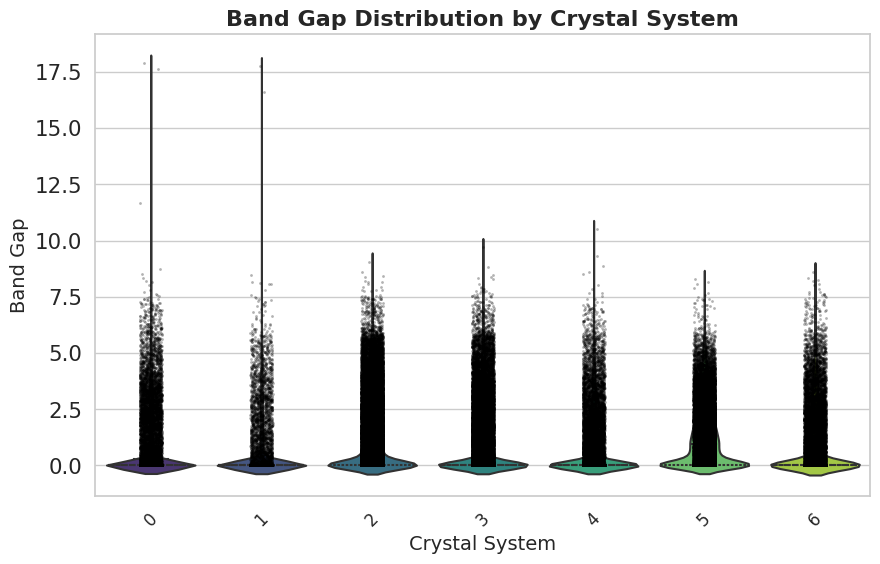

In [ ]:
# Set Seaborn theme
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.4)  # Larger fonts for readability

# Create figure
plt.figure(figsize=(10, 6))

# Violin plot with better aesthetics
sns.violinplot(
    x=df["Crystal System"],
    y=df["Band Gap"],
    hue=None,  # Fix warning
    palette="viridis",  # Better color contrast
    inner="quartile",  # Show quartiles inside the violin
    linewidth=1.5  # Improve line thickness
)

# Add scatter points to show real data
sns.stripplot(
    x=df["Crystal System"],
    y=df["Band Gap"],
    color="black",
    size=2,  # Smaller points
    jitter=True,  # Spread out points
    alpha=0.3  # Slight transparency
)

# Titles & Labels
plt.title("Band Gap Distribution by Crystal System", fontsize=16, fontweight="bold")
plt.xlabel("Crystal System", fontsize=14)
plt.ylabel("Band Gap", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12, rotation=45)

# Show the plot
plt.show()


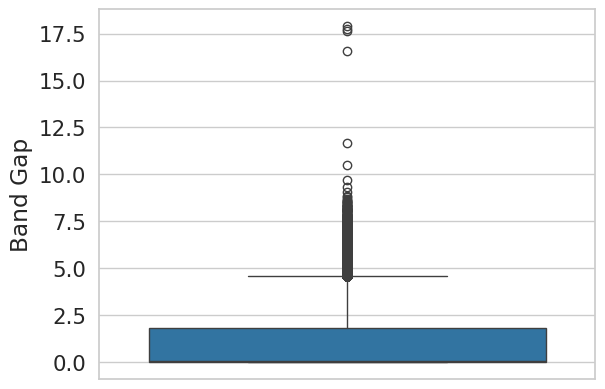

In [ ]:
#Box plot
sns.boxplot(y=df["Band Gap"])
plt.show()

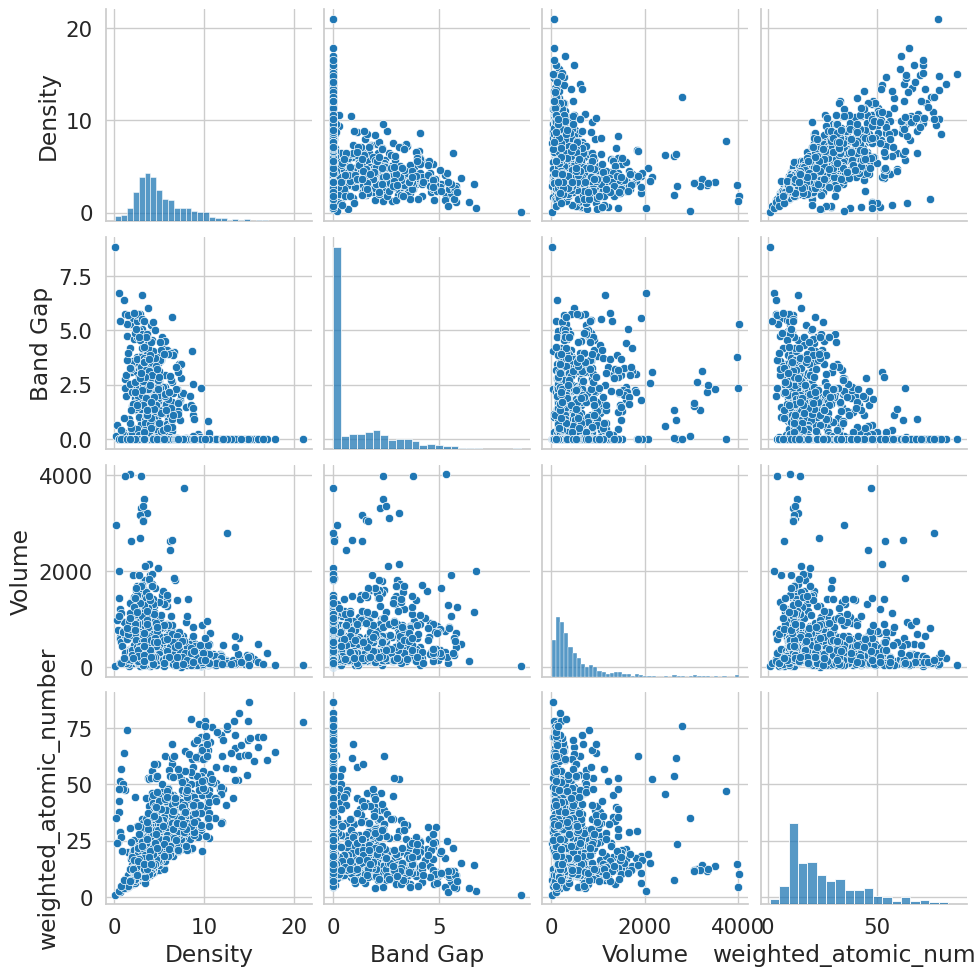

In [ ]:
#Pair plot
sns.pairplot(df[['Density', 'Band Gap', 'Volume', 'weighted_atomic_number']].sample(1000))
plt.show()

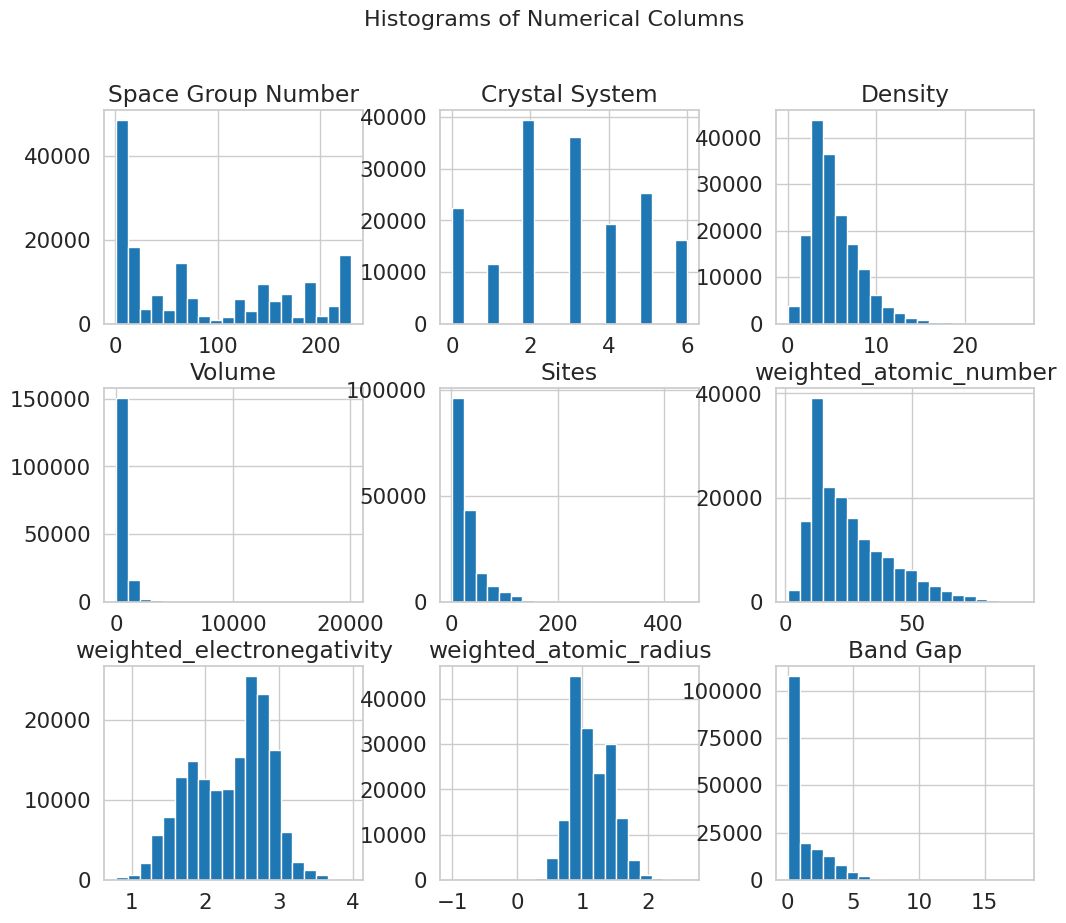

In [ ]:
#Histograms for numerical columns
df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.show()


## Preliminary insights
1. Feature Influence on Band Gap:
- The dataset includes key material properties like density, volume, crystal system, and space group, which could be critical in determining band gaps.
- Weighted atomic properties (atomic number, electronegativity, and atomic radius) could reveal strong correlations with semiconductor behavior.

2. Material Classification Trends:
- Some materials in the dataset have a band gap of 0.0 eV, indicating they are metallic rather than semiconducting.
- Distinguishing between metals, semiconductors, and insulators could be valuable for model training.

3. Potential for Predictive Modeling:
- If the dataset has a diverse range of band gap values, machine learning models can be trained to generalize well.
- Feature engineering (such as including electron density, magnetic properties, and site occupancy) might improve model accuracy.

4. Computational Efficiency:
- Comparing AI-based predictions to DFT calculations can provide insights into time savings.
- If ML models reduce computation time significantly while maintaining accuracy, this could support wider adoption in semiconductor research.

5. Impact on Sustainability:
- If AI-driven models accurately predict semiconductor properties, they could minimize material waste and improve fabrication efficiency.
- Identifying alternative materials with optimized properties may reduce reliance on rare or expensive elements.

## Winsorization (Cap outlier values)

In [ ]:
import pandas as pd

# Assume your DataFrame 'df' is already loaded and cleaned (e.g., with no missing values).
# 'Band Gap' is your target variable.

# Display initial shape
print("Initial dataset shape:", df.shape)

# -------------------------
# 1. Compute IQR for 'Band Gap'
# -------------------------
q1 = df['Band Gap'].quantile(0.25)
q3 = df['Band Gap'].quantile(0.75)
iqr = q3 - q1

# Define acceptable bounds using a typical multiplier (e.g., 1.5)
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print("Q1:", q1, "Q3:", q3, "IQR:", iqr)
print("Lower bound:", lower_bound, "Upper bound:", upper_bound)


# -------------------------
# Winsorization (Cap outlier values)
# -------------------------
# Instead of dropping rows, cap the 'Band Gap' values to the lower and upper bounds.
df_winsorized = df.copy()
df_winsorized['Band Gap'] = df_winsorized['Band Gap'].clip(lower_bound, upper_bound)

print("\n[Winsorization Method]")
print("Sample of 'Band Gap' values before winsorization:")
print(df['Band Gap'].describe())
print("\nSample of 'Band Gap' values after winsorization:")
print(df_winsorized['Band Gap'].describe())


Initial dataset shape: (170359, 9)
Q1: 0.0 Q3: 1.8289499999999994 IQR: 1.8289499999999994
Lower bound: -2.7434249999999993 Upper bound: 4.572374999999999

[Removal Method]
Original number of samples: 170359
Number of samples after outlier removal: 164132

[Winsorization Method]
Sample of 'Band Gap' values before winsorization:
count    170359.000000
mean          1.043769
std           1.490015
min           0.000000
25%           0.000000
50%           0.068300
75%           1.828950
max          10.522900
Name: Band Gap, dtype: float64

Sample of 'Band Gap' values after winsorization:
count    170359.000000
mean          1.013437
std           1.400444
min           0.000000
25%           0.000000
50%           0.068300
75%           1.828950
max           4.572375
Name: Band Gap, dtype: float64


## Ensemble Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


X = df_winsorized.drop(columns=['Band Gap',"Crystal System"])
y = df_winsorized['Band Gap']


# Split into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# -------------------------
# 2. Standardize the Features
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------
# 3. Define Base Models for Stacking
# -------------------------
# Here we include seven base models:
# 1. Random Forest
# 2. XGBoost
# 3. Gradient Boosting
# 4. K-Neighbors

estimators = [
    ('rf', RandomForestRegressor(
            n_estimators=300,
            max_depth=30,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42
        )),
    ('xgb', XGBRegressor(
            n_estimators=200,
            random_state=42,
            verbosity=0
        )),
    ('gb', GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            random_state=42
        )),
    ('knn', KNeighborsRegressor(n_neighbors=5))


]

# -------------------------
# 4. Define the Final Estimator for Stacking
# -------------------------
# We use Ridge Regression as the final (meta) estimator.
final_estimator = Ridge(alpha=1.0)

# -------------------------
# 5. Create and Train the Stacking Regressor
# -------------------------
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

stack_reg.fit(X_train_scaled, y_train)

# -------------------------
# 6. Evaluate the Stacking Ensemble on the Test Set
# -------------------------
y_pred = stack_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Stacking Ensemble Performance with Additional Base Models:")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2: {r2:.4f}")


Training set shape: (136287, 7)
Testing set shape: (34072, 7)
Stacking Ensemble Performance with Additional Base Models:
Test MSE: 0.8349
Test RMSE: 0.9137
Test R^2: 0.5731

## Random Forest

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Prepare features and target for modeling
#    (Assuming 'Band Gap' is still your target column after cleaning)
X = df.drop(columns=["Band Gap"])
y = df["Band Gap"]

# 3. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (136287, 8)
Test set size: (34072, 8)


In [ ]:
# 4. Train Random Forest model with best parameters
rf_best = RandomForestRegressor(
    n_estimators=300,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

# 5. Evaluate model on test set
y_pred = rf_best.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test set performance - MSE: {test_mse:.4f}, R²: {test_r2:.4f}")


Test set performance - MSE: 0.9684, R²: 0.5634


## Best Models

In [ ]:
# %% [code]
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assume X_train and X_test have already been defined.
# Apply StandardScaler to the train and test data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Standard scaling applied. Shapes -> X_train_scaled:", X_train_scaled.shape, ", X_test_scaled:", X_test_scaled.shape)

# Define a dictionary of models to evaluate (using the scaled features).
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR(C=1.0, epsilon=0.2),
    "K-Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# Initialize a list to collect evaluation results.
results = []

# Loop through each model, train it on the scaled training data,
# predict on the scaled test data, and evaluate performance.
for name, model in models.items():
    # Train the model on scaled training data.
    model.fit(X_train_scaled, y_train)
    # Make predictions using the scaled test data.
    y_pred_model = model.predict(X_test_scaled)
    # Calculate performance metrics.
    mse_model = mean_squared_error(y_test, y_pred_model)
    r2_model = r2_score(y_test, y_pred_model)
    # Append the results.
    results.append([name, mse_model, r2_model])
    print(f"{name} - MSE: {mse_model:.4f} | R²: {r2_model:.4f}")

# Create a DataFrame summarizing the results for easy comparison.
results_df = pd.DataFrame(results, columns=["Model", "MSE", "R2 Score"])
print("\nComparison of Model Performance on Test Data:")
print(results_df)



Standard scaling applied. Shapes -> X_train_scaled: (136287, 8) , X_test_scaled: (34072, 8)
Random Forest - MSE: 0.9746 | R²: 0.5606
Gradient Boosting - MSE: 1.3911 | R²: 0.3728
Linear Regression - MSE: 1.6805 | R²: 0.2423
Support Vector Regression - MSE: 1.4912 | R²: 0.3277
K-Neighbors - MSE: 1.2497 | R²: 0.4366

Comparison of Model Performance on Test Data:
                       Model       MSE  R2 Score
0              Random Forest  0.974611  0.560580
1          Gradient Boosting  1.391099  0.372799
2          Linear Regression  1.680474  0.242329
3  Support Vector Regression  1.491188  0.327672
4                K-Neighbors  1.249701  0.436551


<ipython-input-56-021993175851>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[0], data=results_df, x="Model", y="MSE", palette="coolwarm")
<ipython-input-56-021993175851>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axs[1], data=results_df, x="Model", y="R2 Score", palette="viridis")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

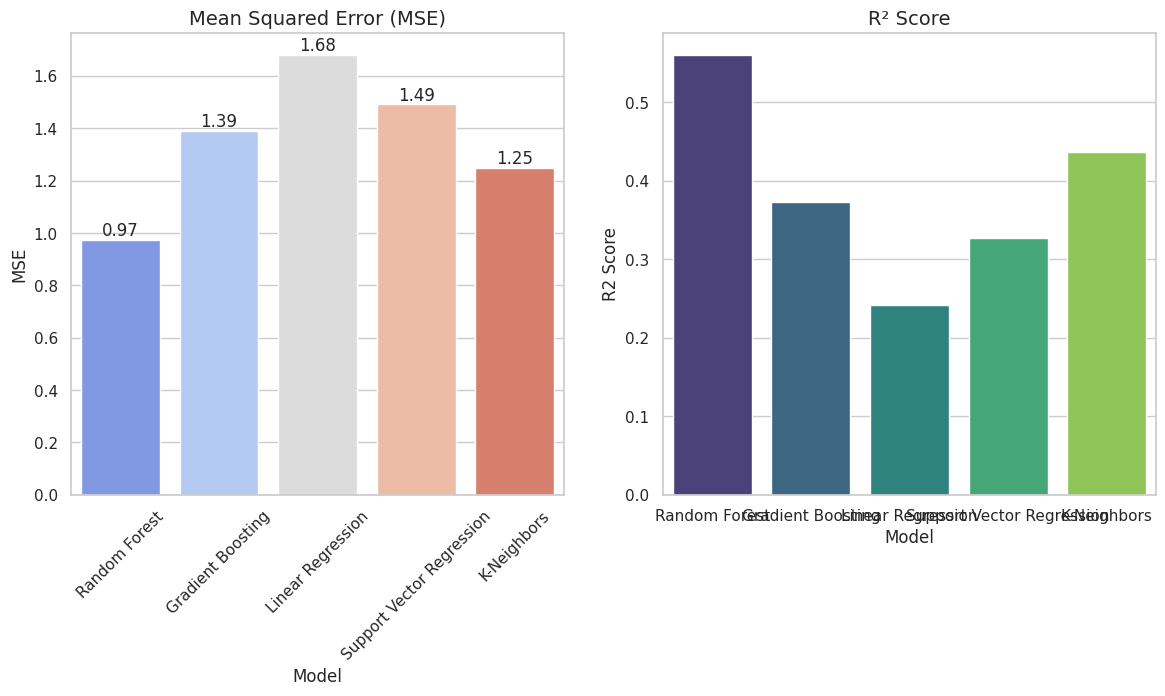

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Set a consistent seaborn style
sns.set(style="whitegrid")

# =========================================================
# 1. Combined Bar Plots: MSE and R² Score Comparison
# =========================================================

# Create a figure with two side-by-side subplots
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))

# Left: Mean Squared Error (MSE)
sns.barplot(ax=axs[0], data=results_df, x="Model", y="MSE", palette="coolwarm")
axs[0].set_title("Mean Squared Error (MSE)", fontsize=14)
axs[0].set_xlabel("Model", fontsize=12)
axs[0].set_ylabel("MSE", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.2f', label_type='edge')

# Right: R² Score
sns.barplot(ax=axs[1], data=results_df, x="Model", y="R2 Score", palette="viridis")
axs[1].set_title("R² Score", fontsize=14)
axs[1].set_xlabel("Model", fontsize=12)
axs[1].set_ylabel("R² Score", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.2f', label_type='edge')

plt.tight_layout()
plt.show()



## Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the hyperparameter grid to search over.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest regressor.
rf_model = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV object. We use 5-fold cross-validation,
# negative mean squared error as the scoring metric, and n_jobs=-1 to use all processors.
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit grid search on the scaled training data.
grid_search.fit(X_train_scaled, y_train)

# Output the best hyperparameters and best cross-validation score.
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation MSE: ", -grid_search.best_score_)

# Retrieve the best estimator.
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set.
y_pred_best_rf = best_rf.predict(X_test_scaled)
mse_best = mean_squared_error(y_test, y_pred_best_rf)
r2_best = r2_score(y_test, y_pred_best_rf)
print(f"Test set performance of best RF model - MSE: {mse_best:.4f}, R²: {r2_best:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation MSE:  1.004000495643042
Test set performance of best RF model - MSE: 0.9682, R²: 0.5635


Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation MSE:  1.004000495643042
Test set performance of best RF model - MSE: 0.9682, R²: 0.5635

Pivot table for MSE (max_depth vs. n_estimators):
param_n_estimators       100       200       300
param_max_depth                                 
10                  1.260363  1.259355  1.258949
20                  1.029419  1.024414  1.023131
30                  1.011456  1.005403  1.004000
None                1.012023  1.005728  1.004264


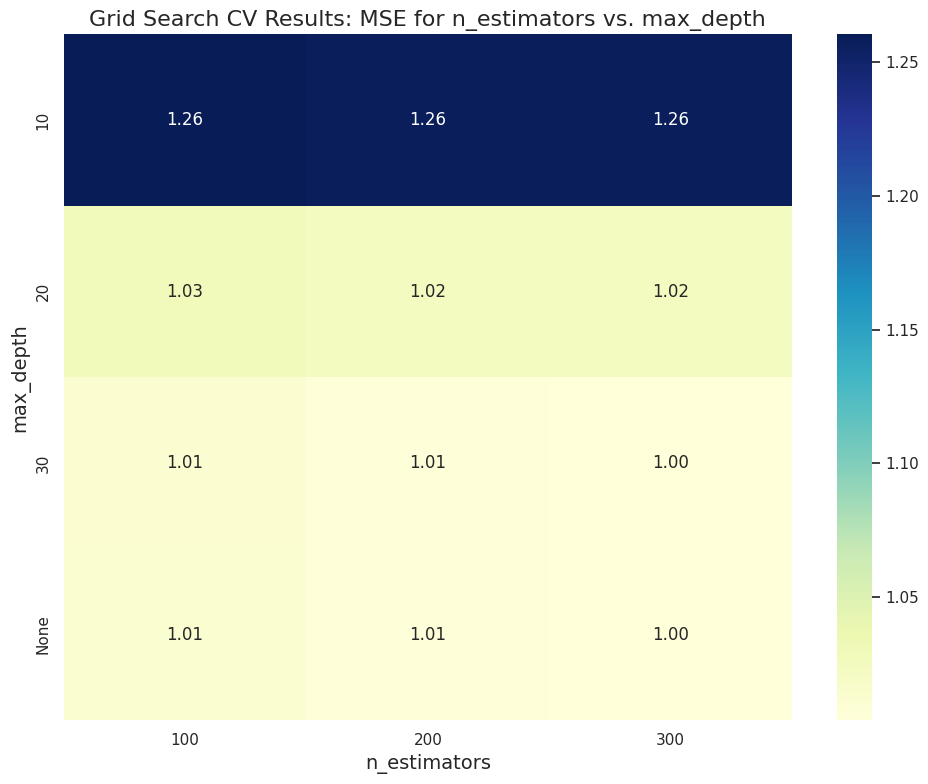

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# 1. Print Grid Search Results
# -------------------------------
# (Assuming grid_search was run as shown previously)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Since scoring was negative MSE, multiply by -1
best_cv_mse = -grid_search.best_score_
print("Best cross-validation MSE: ", best_cv_mse)

# Retrieve the best estimator from grid search and evaluate on the test set.
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)
mse_best = mean_squared_error(y_test, y_pred_best_rf)
r2_best = r2_score(y_test, y_pred_best_rf)
print(f"Test set performance of best RF model - MSE: {mse_best:.4f}, R²: {r2_best:.4f}")

# -------------------------------
# 2. Create Pivot Table and Heatmap from Grid Search CV Results
# -------------------------------

# Convert the cv_results_ into a DataFrame
cv_results_df = pd.DataFrame(grid_search.cv_results_)
# Convert negative MSE to positive values for interpretability.
cv_results_df['MSE'] = -cv_results_df['mean_test_score']

# Print available columns for reference (uncomment if needed)
# print("Columns in cv_results_df:\n", cv_results_df.columns.tolist())

# Convert 'param_max_depth' to string to ensure consistency (for example, if None appears)
if 'param_max_depth' in cv_results_df.columns:
    cv_results_df['param_max_depth'] = cv_results_df['param_max_depth'].astype(str).fillna('None')

# Optionally filter for rows with best values for other parameters (if present in the grid)
if all(param in cv_results_df.columns for param in ['param_min_samples_split', 'param_min_samples_leaf']):
    filtered_df = cv_results_df[
        (cv_results_df['param_min_samples_split'] == best_params['min_samples_split']) &
        (cv_results_df['param_min_samples_leaf'] == best_params['min_samples_leaf'])
    ].copy()
else:
    filtered_df = cv_results_df.copy()

# Ensure that the pivot columns match those defined in your param_grid.
required_cols = ['param_max_depth', 'param_n_estimators', 'MSE']
for col in required_cols:
    if col not in filtered_df.columns:
        raise ValueError(f"Column '{col}' not found in cv_results_df. Please check your parameter names.")

# Create a pivot table with rows as max_depth and columns as n_estimators.
pivot_table = filtered_df.pivot(index="param_max_depth", columns="param_n_estimators", values="MSE")

print("\nPivot table for MSE (max_depth vs. n_estimators):")
print(pivot_table)

# Set up a clean aesthetic for plotting.
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Plot the heatmap.
heatmap = sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Grid Search CV Results: MSE for n_estimators vs. max_depth", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("max_depth", fontsize=14)
plt.tight_layout()
plt.show()




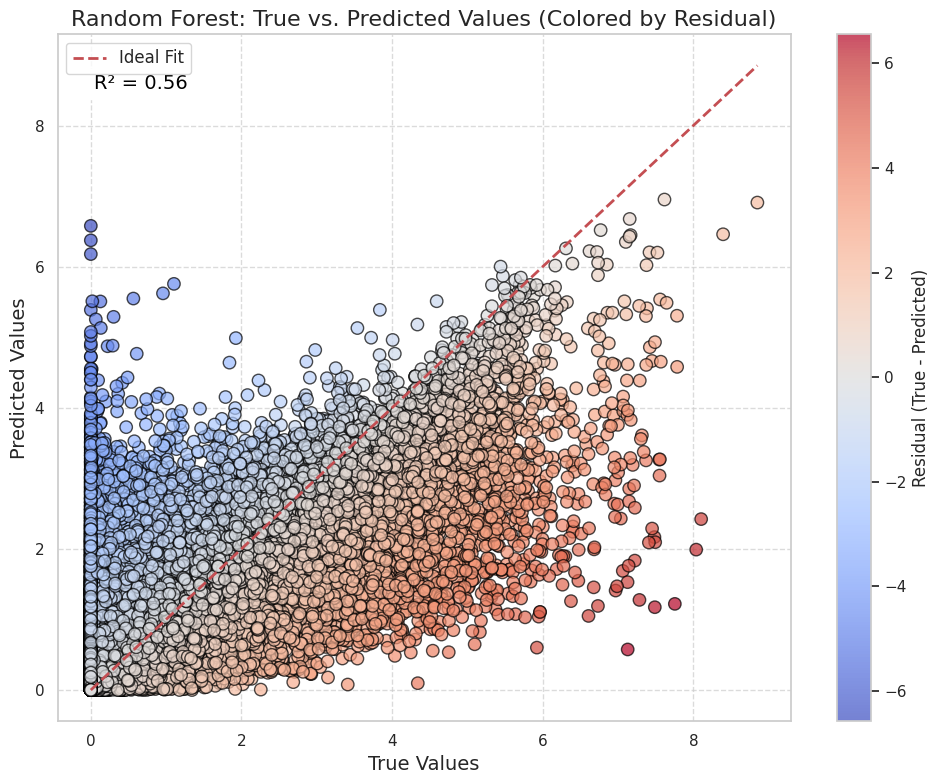

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid")


# Calculate residuals
residuals = y_test - y_pred_rf

# Calculate R² for annotation
r2_val = r2_score(y_test, y_pred_rf)

# Create a scatter plot colored by residuals
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    x=y_test,
    y=y_pred_rf,
    c=residuals,            # Color points by residual
    cmap='coolwarm',        # Diverging colormap for +/- residuals
    alpha=0.7,
    s=80,
    edgecolor='black'
)

# Plot the ideal line (y = x)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2, label="Ideal Fit"
)

# Add a colorbar to interpret the residual scale
cbar = plt.colorbar(scatter)
cbar.set_label('Residual (True - Predicted)', fontsize=12)

plt.title("Random Forest: True vs. Predicted Values (Colored by Residual)", fontsize=16)
plt.xlabel("True Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)

# Annotate the R² value in the upper-left corner of the plot
plt.annotate(
    f'R² = {r2_val:.2f}',
    xy=(0.05, 0.92),
    xycoords='axes fraction',
    fontsize=14,
    backgroundcolor='white',
    color='black'
)

plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## ORCA vs RF

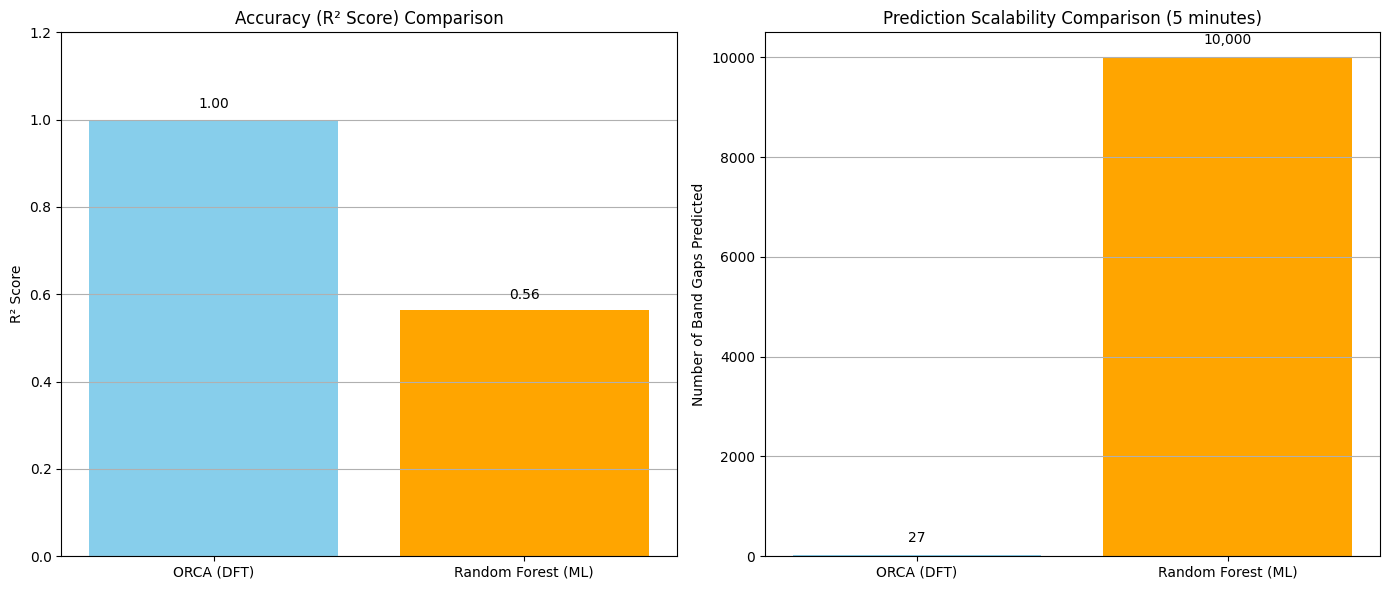

In [ ]:
import matplotlib.pyplot as plt

# Data
methods = ['ORCA (DFT)', 'Random Forest (ML)']
r2_scores = [1.0, 0.5635]  # Accuracy comparison
band_gaps_predicted = [27, 10000]  # Scalability (hypothetical numbers)

# Create the figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Accuracy (R² Score) Comparison
bars1 = axs[0].bar(methods, r2_scores, color=['skyblue', 'orange'])
axs[0].set_title('Accuracy (R² Score) Comparison')
axs[0].set_ylabel('R² Score')
axs[0].set_ylim(0, 1.2)
axs[0].grid(axis='y')

# Annotate bars
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

# Plot 2: Scalability (Number of Predictions in 5 min)
bars2 = axs[1].bar(methods, band_gaps_predicted, color=['skyblue', 'orange'])
axs[1].set_title('Prediction Scalability Comparison (5 minutes)')
axs[1].set_ylabel('Number of Band Gaps Predicted')
axs[1].grid(axis='y')

# Annotate bars
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, yval + 200, f'{yval:,}', ha='center', va='bottom')

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


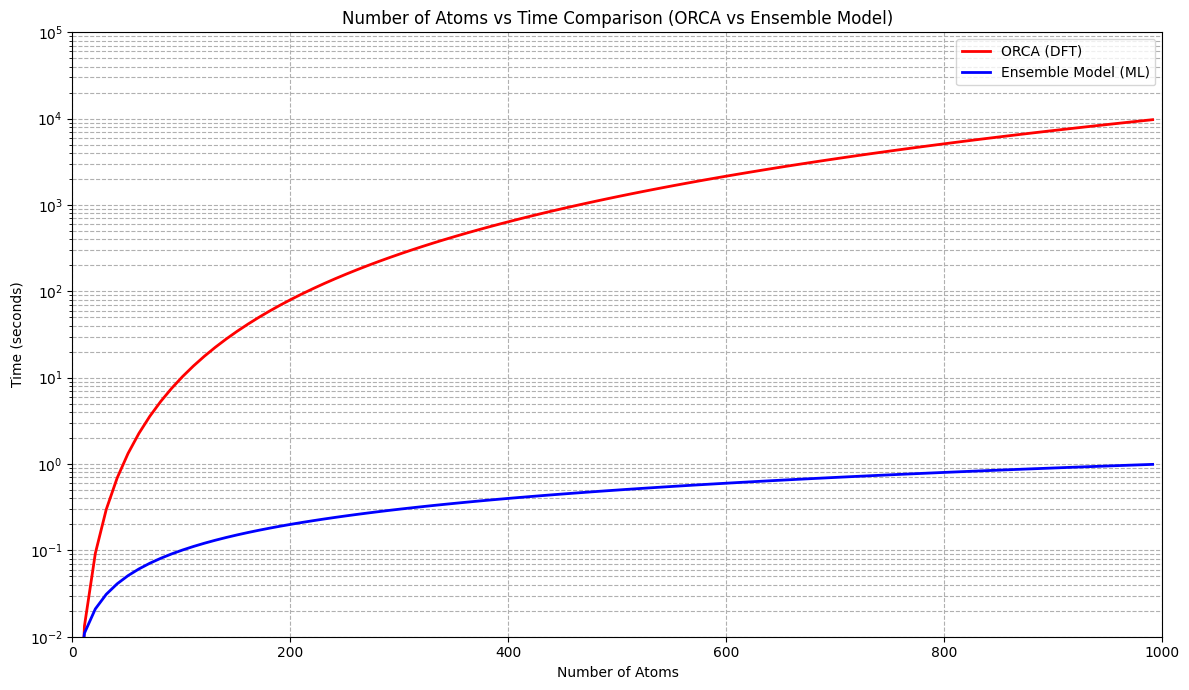

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of atoms
num_atoms = np.arange(1, 1001, 10)

# Time simulations
orca_time = 0.00001 * (num_atoms ** 3)  # cubic scaling for ORCA
rf_time = 0.001 * num_atoms  # linear scaling for RF

# Plot
plt.figure(figsize=(12, 7))
plt.plot(num_atoms, orca_time, label='ORCA (DFT)', color='red', linewidth=2)
plt.plot(num_atoms, rf_time, label='Ensemble Model (ML)', color='blue', linewidth=2)
plt.title('Number of Atoms vs Time Comparison (ORCA vs Ensemble Model)')
plt.xlabel('Number of Atoms')
plt.ylabel('Time (seconds)')
plt.yscale('log')  # log scale
plt.ylim(1e-2, 1e5)  # <<=== THIS sets the y-axis range from 10^-2 to 10^5
plt.xlim(0, 1000)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()




## Deep Learning

In [ ]:
# %% [code]
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random

# PyTorch Geometric imports
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# -------------------------
# 1. Load & Preprocess Data
# -------------------------

# Example: The user’s DataFrame is already loaded as 'df'
# with columns like: ['Space Group Number', 'Crystal System', 'Density',
# 'Volume', 'Sites', 'weighted_atomic_number', 'weighted_electronegativity',
# 'weighted_atomic_radius', 'Band Gap'].

# We'll assume `df` is already cleaned, and 'Band Gap' is your target.
# If you haven’t loaded it yet, uncomment the line below:
# df = pd.read_csv('/path/to/yourfile.csv')

# Move "Band Gap" column to the last position (already done in your snippet).
# Encode 'Crystal System' if it’s categorical (already shown in your snippet).
# Example:
# label_encoder = LabelEncoder()
# df['Crystal System'] = label_encoder.fit_transform(df['Crystal System'])

# For simplicity, let's drop any rows with NaNs.
df.dropna(inplace=True)

# Identify your target column
target_col = 'Band Gap'

# Separate features from target
feature_columns = [col for col in df.columns if col != target_col]
X = df[feature_columns]
y = df[target_col]

# Split into training and test sets (tabular form, initially)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# ----------------------------------------------------
# 2. Convert Each Row to a Synthetic Graph (One per Row)
# ----------------------------------------------------
def create_graph_from_row(features: np.ndarray, target: float):
    """
    Creates a small chain-graph Data object from a single row of tabular data.

    - Each numeric feature is treated as one 'node' with a single feature value.
    - We connect nodes in a sequential chain: 0->1, 1->2, ...
    - The graph label is the target (e.g. Band Gap).
    """
    num_nodes = len(features)

    # Node feature matrix: shape (num_nodes, 1)
    x = torch.tensor(features, dtype=torch.float).view(-1, 1)

    # Build edges for a chain structure
    edge_index_list = []
    for i in range(num_nodes - 1):
        edge_index_list.append([i, i+1])
        edge_index_list.append([i+1, i])
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    # Graph-level label (regression target)
    y_val = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y_val)

# Convert training rows to a list of PyG Data objects
train_graphs = []
for row, val in zip(X_train.values, y_train.values):
    train_graphs.append(create_graph_from_row(row, val))

# Convert test rows
test_graphs = []
for row, val in zip(X_test.values, y_test.values):
    test_graphs.append(create_graph_from_row(row, val))

print("Number of training graphs:", len(train_graphs))
print("Number of testing graphs:", len(test_graphs))

# Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# -----------------------
# 3. Define a Simple GNN
# -----------------------
class GNNRegressor(nn.Module):
    def __init__(self, hidden_channels):
        super(GNNRegressor, self).__init__()
        self.conv1 = GCNConv(in_channels=1, out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)  # Regression output

    def forward(self, data):
        # x: (num_nodes_in_batch, num_features_per_node)
        # edge_index: (2, num_edges_in_batch)
        # batch: a list mapping each node to its graph index
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # Global mean pooling aggregates all nodes in each graph to a single embedding
        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out

# Pick your device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNRegressor(hidden_channels=32).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# -----------------------
# 4. Training Loop
# -----------------------
def train_epoch(loader):
    model.train()
    total_loss = 0
    for batch_data in loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        out = model(batch_data).flatten()
        loss = loss_fn(out, batch_data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_data.num_graphs
    return total_loss / len(loader.dataset)

def eval_mse(loader):
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for batch_data in loader:
            batch_data = batch_data.to(device)
            out = model(batch_data).flatten()
            y_pred_list.append(out.cpu().numpy())
            y_true_list.append(batch_data.y.cpu().numpy())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    mse = mean_squared_error(y_true, y_pred)
    return mse

num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(train_loader)
    test_mse = eval_mse(test_loader)
    print(f"Epoch {epoch:02d} - Train Loss: {train_loss:.4f}, Test MSE: {test_mse:.4f}")



/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Data shapes:
X_train: (136287, 8) y_train: (136287,)
X_test: (34072, 8) y_test: (34072,)
Number of training graphs: 136287
Number of testing graphs: 34072


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01 - Train Loss: 2.0819, Test MSE: 1.9532
Epoch 02 - Train Loss: 1.9529, Test MSE: 1.9531
Epoch 03 - Train Loss: 1.9440, Test MSE: 1.9775
Epoch 04 - Train Loss: 1.9353, Test MSE: 1.9194
Epoch 05 - Train Loss: 1.9245, Test MSE: 1.9103
Epoch 06 - Train Loss: 1.9147, Test MSE: 1.9725
Epoch 07 - Train Loss: 1.9219, Test MSE: 1.9159
Epoch 08 - Train Loss: 1.9007, Test MSE: 1.9312
Epoch 09 - Train Loss: 1.9170, Test MSE: 1.9245
Epoch 10 - Train Loss: 1.9089, Test MSE: 1.8753
Epoch 11 - Train Loss: 1.8999, Test MSE: 1.8750
Epoch 12 - Train Loss: 1.8966, Test MSE: 1.8853
Epoch 13 - Train Loss: 1.8697, Test MSE: 1.8431
Epoch 14 - Train Loss: 1.8838, Test MSE: 1.9188
Epoch 15 - Train Loss: 1.8779, Test MSE: 1.8749
Epoch 16 - Train Loss: 1.8632, Test MSE: 1.8415
Epoch 17 - Train Loss: 1.8642, Test MSE: 1.8499
Epoch 18 - Train Loss: 1.8592, Test MSE: 1.8569
Epoch 19 - Train Loss: 1.8558, Test MSE: 1.8457
Epoch 20 - Train Loss: 1.8581, Test MSE: 1.8445
Epoch 21 - Train Loss: 1.8539, Test MSE:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv, SAGEConv, global_mean_pool

# -------------------------------
# Define Alternative GNN Models
# -------------------------------

# Model using Graph Attention Networks (GATConv)
class GNNRegressorGAT(nn.Module):
    def __init__(self, hidden_channels, heads=2, dropout=0.1):
        super(GNNRegressorGAT, self).__init__()
        # The first layer outputs hidden_channels features per head, so total = hidden_channels * heads.
        self.conv1 = GATConv(in_channels=1, out_channels=hidden_channels, heads=heads, dropout=dropout)
        # Second layer: aggregate head outputs (heads=1 means a single output per node)
        self.conv2 = GATConv(in_channels=hidden_channels * heads, out_channels=hidden_channels, heads=1, dropout=dropout)
        self.lin = nn.Linear(hidden_channels, 1)  # Regression layer

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First GAT layer + activation
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        # Second GAT layer + activation
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        # Global pooling: aggregate node features to a graph-level representation
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Model using GraphSAGE (SAGEConv)
class GNNRegressorSAGE(nn.Module):
    def __init__(self, hidden_channels):
        super(GNNRegressorSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels=1, out_channels=hidden_channels)
        self.conv2 = SAGEConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)  # Regression layer

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# -------------------------------
# Choose Model and Setup Training
# -------------------------------

# Set this flag to True to use the GAT-based model, or False to use GraphSAGE.
use_gat = True

hidden_channels = 32  # Adjust hidden dimension as needed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if use_gat:
    model = GNNRegressorGAT(hidden_channels, heads=2, dropout=0.1)
    print("Using GAT-based model.")
else:
    model = GNNRegressorSAGE(hidden_channels)
    print("Using GraphSAGE-based model.")

model = model.to(device)

# Define optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# -------------------------------
# Training and Evaluation Functions
# -------------------------------

def train_epoch(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).flatten()  # Output shape: (batch_size,)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_mse(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).flatten()
            y_true.append(data.y.cpu())
            y_pred.append(out.cpu())
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    mse = F.mse_loss(y_pred, y_true)
    return mse.item()

# -------------------------------
# Training Loop
# -------------------------------

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(train_loader)
    test_mse = eval_mse(test_loader)
    print(f"Epoch {epoch:02d} - Train Loss: {train_loss:.4f}, Test MSE: {test_mse:.4f}")


Using GAT-based model.
Epoch 01 - Train Loss: 2.0715, Test MSE: 1.9928
Epoch 02 - Train Loss: 1.9648, Test MSE: 1.8791
Epoch 03 - Train Loss: 1.8422, Test MSE: 1.7920
Epoch 04 - Train Loss: 1.8090, Test MSE: 1.7615
Epoch 05 - Train Loss: 2.0356, Test MSE: 1.9090
Epoch 06 - Train Loss: 1.8491, Test MSE: 1.8972
Epoch 07 - Train Loss: 1.8430, Test MSE: 1.8381
Epoch 08 - Train Loss: 1.8380, Test MSE: 1.9581
Epoch 09 - Train Loss: 1.8402, Test MSE: 1.8932
Epoch 10 - Train Loss: 1.8326, Test MSE: 1.9426
Epoch 11 - Train Loss: 1.8347, Test MSE: 1.9462
Epoch 12 - Train Loss: 1.8207, Test MSE: 1.8731
Epoch 13 - Train Loss: 1.8419, Test MSE: 1.8833
Epoch 14 - Train Loss: 1.8161, Test MSE: 1.8879
Epoch 15 - Train Loss: 1.8179, Test MSE: 1.8232
Epoch 16 - Train Loss: 1.8135, Test MSE: 1.9527
Epoch 17 - Train Loss: 1.8100, Test MSE: 1.9033
Epoch 18 - Train Loss: 1.8150, Test MSE: 1.8351
Epoch 19 - Train Loss: 1.8158, Test MSE: 1.8693
Epoch 20 - Train Loss: 1.8174, Test MSE: 1.9634


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# -------------------------
# 1. Load & Preprocess Data
# -------------------------
# For this example, assume your DataFrame 'df' is already loaded and contains your data.
# Ensure 'Band Gap' (or your target) and feature columns are available.

# Example: Uncomment and modify the following line to load your dataset
# df = pd.read_csv('/path/to/your_dataset.csv')

# Drop rows with missing values (or use imputation)
df.dropna(inplace=True)

# Assume 'Band Gap' is your target column
target_col = 'Band Gap'
feature_columns = [col for col in df.columns if col != target_col]

# Split data into features (X) and target (y)
X = df[feature_columns]
y = df[target_col]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# ----------------------------------------------------
# 2. Convert Each Row to a Synthetic Graph (Chain Graph)
# ----------------------------------------------------
def create_graph_from_row(features: np.ndarray, target: float):
    """
    Create a simple chain graph from a single row of tabular data.

    Each feature becomes a node with a single feature value.
    Nodes are connected sequentially (0->1, 1->2, ...).
    The graph label is the target value.
    """
    num_nodes = len(features)
    x = torch.tensor(features, dtype=torch.float).view(-1, 1)

    edge_index_list = []
    for i in range(num_nodes - 1):
        edge_index_list.append([i, i + 1])
        edge_index_list.append([i + 1, i])
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    y_val = torch.tensor([target], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y_val)

# Create lists of PyG Data objects for training and testing
train_graphs = [create_graph_from_row(row, val) for row, val in zip(X_train.values, y_train.values)]
test_graphs  = [create_graph_from_row(row, val) for row, val in zip(X_test.values, y_test.values)]

print("Number of training graphs:", len(train_graphs))
print("Number of test graphs:", len(test_graphs))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

# --------------------------
# 3. Define the GraphSAGE Model
# --------------------------
class GNNRegressorSAGE(nn.Module):
    def __init__(self, hidden_channels):
        super(GNNRegressorSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels=1, out_channels=hidden_channels)
        self.conv2 = SAGEConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)  # Output regression value

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Global mean pooling to get a graph-level embedding
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNRegressorSAGE(hidden_channels=32).to(device)

# --------------------------
# 4. Set Up Training Components
# --------------------------
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

def train_epoch(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).flatten()  # Expected shape: (batch_size,)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_mse(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).flatten()
            y_true.append(data.y.cpu())
            y_pred.append(out.cpu())
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    mse = F.mse_loss(y_pred, y_true)
    return mse.item()

# --------------------------
# 5. Training Loop for GraphSAGE Model
# --------------------------
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(train_loader)
    test_mse = eval_mse(test_loader)
    print(f"Epoch {epoch:02d} - Train Loss: {train_loss:.4f}, Test MSE: {test_mse:.4f}")


Training data shape: (136287, 8)
Testing data shape: (34072, 8)
Number of training graphs: 136287
Number of test graphs: 34072


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01 - Train Loss: 3.4400, Test MSE: 1.9196
Epoch 02 - Train Loss: 1.8971, Test MSE: 1.9146
Epoch 03 - Train Loss: 1.7680, Test MSE: 1.7211
Epoch 04 - Train Loss: 1.6676, Test MSE: 1.6085
Epoch 05 - Train Loss: 1.6138, Test MSE: 1.6648
Epoch 06 - Train Loss: 1.6088, Test MSE: 1.6472
Epoch 07 - Train Loss: 1.6034, Test MSE: 1.6424
Epoch 08 - Train Loss: 1.5926, Test MSE: 1.6332
Epoch 09 - Train Loss: 1.5826, Test MSE: 1.5836
Epoch 10 - Train Loss: 1.5932, Test MSE: 1.5850
Epoch 11 - Train Loss: 1.5800, Test MSE: 1.5711
Epoch 12 - Train Loss: 1.5750, Test MSE: 1.5736
Epoch 13 - Train Loss: 1.5761, Test MSE: 1.5826
Epoch 14 - Train Loss: 1.5732, Test MSE: 1.6007
Epoch 15 - Train Loss: 1.5689, Test MSE: 1.5680
Epoch 16 - Train Loss: 1.5654, Test MSE: 1.5653
Epoch 17 - Train Loss: 1.5548, Test MSE: 1.5511
Epoch 18 - Train Loss: 1.5609, Test MSE: 1.5483
Epoch 19 - Train Loss: 1.5562, Test MSE: 1.5628
Epoch 20 - Train Loss: 1.5503, Test MSE: 1.5539


In [ ]:
# -------------------------------
# 2. Graph Construction Functions
# -------------------------------

def create_chain_graph(features: np.ndarray, target: float):
    """Creates a chain graph: each node (one feature per node) is connected sequentially."""
    num_nodes = len(features)
    x = torch.tensor(features, dtype=torch.float).view(-1, 1)

    edge_index_list = []
    for i in range(num_nodes - 1):
        edge_index_list.append([i, i + 1])
        edge_index_list.append([i + 1, i])
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    y_val = torch.tensor([target], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y_val)

def create_complete_graph(features: np.ndarray, target: float):
    """
    Creates a complete graph: every node is connected to every other node.
    This may better capture interactions between all feature pairs.
    """
    num_nodes = len(features)
    x = torch.tensor(features, dtype=torch.float).view(-1, 1)

    edge_index_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                edge_index_list.append([i, j])
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

    y_val = torch.tensor([target], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, y=y_val)

# Choose graph construction method: "chain" or "complete"
graph_type = "complete"  # Change to "chain" to use the original chain graph

def create_graph(features: np.ndarray, target: float):
    if graph_type == "chain":
        return create_chain_graph(features, target)
    elif graph_type == "complete":
        return create_complete_graph(features, target)
    else:
        raise ValueError("Unknown graph_type. Use 'chain' or 'complete'.")

# Create Data objects for training and testing
train_graphs = [create_graph(row, val) for row, val in zip(X_train.values, y_train.values)]
test_graphs  = [create_graph(row, val) for row, val in zip(X_test.values, y_test.values)]

print("Number of training graphs:", len(train_graphs))
print("Number of test graphs:", len(test_graphs))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

# -------------------------------
# 3. Define the GraphSAGE-Based Model
# -------------------------------
class GNNRegressorSAGE(nn.Module):
    def __init__(self, hidden_channels):
        super(GNNRegressorSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels=1, out_channels=hidden_channels)
        self.conv2 = SAGEConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)  # regression output

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Global mean pooling to get a graph-level feature vector
        x = global_mean_pool(x, batch)
        return self.lin(x)

# -------------------------------
# 4. Hyperparameter Tuning & Training Loop
# -------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a function for training and evaluation given hyperparameters
def train_and_evaluate(hidden_channels, learning_rate, num_epochs=10):
    model = GNNRegressorSAGE(hidden_channels=hidden_channels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    def train_epoch(loader):
        model.train()
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data).flatten()
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        return total_loss / len(loader.dataset)

    def eval_mse(loader):
        model.eval()
        y_true_list, y_pred_list = [], []
        with torch.no_grad():
            for data in loader:
                data = data.to(device)
                out = model(data).flatten()
                y_true_list.append(data.y.cpu())
                y_pred_list.append(out.cpu())
        y_true = torch.cat(y_true_list)
        y_pred = torch.cat(y_pred_list)
        mse = F.mse_loss(y_pred, y_true)
        return mse.item()

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(train_loader)
        test_mse = eval_mse(test_loader)
        # For tuning, you can print more concisely or log to a file.
        print(f"Epoch {epoch:02d} | Hidden: {hidden_channels}, LR: {learning_rate} -> Train Loss: {train_loss:.4f}, Test MSE: {test_mse:.4f}")

    return eval_mse(test_loader)

# Define hyperparameter grid to experiment with:
learning_rates = [0.01, 0.005, 0.001]
hidden_channels_list = [32, 64]

results = []
for lr in learning_rates:
    for hidden in hidden_channels_list:
        print(f"\nTraining with hidden_channels = {hidden}, learning_rate = {lr}")
        mse = train_and_evaluate(hidden, lr, num_epochs=10)
        results.append({"hidden_channels": hidden, "learning_rate": lr, "Test_MSE": mse})

# Show the tuning results:
results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df)

# -------------------------------
# 5. Longer Training for the Best Hyperparameters
# -------------------------------
# Suppose from the tuning you decide that:
best_hidden_channels = 64
best_learning_rate = 0.005

print(f"\nTraining longer with best hyperparameters: hidden_channels = {best_hidden_channels}, learning_rate = {best_learning_rate}\n")
best_model = GNNRegressorSAGE(hidden_channels=best_hidden_channels).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
loss_fn = nn.MSELoss()

def train_epoch_model(loader, model, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).flatten()
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_model(loader, model):
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).flatten()
            y_true_list.append(data.y.cpu())
            y_pred_list.append(out.cpu())
    y_true = torch.cat(y_true_list)
    y_pred = torch.cat(y_pred_list)
    mse = F.mse_loss(y_pred, y_true)
    return mse.item()

# Train for a longer period (e.g., 50 epochs)
num_epochs_long = 50
for epoch in range(1, num_epochs_long + 1):
    train_loss = train_epoch_model(train_loader, best_model, optimizer)
    test_mse = eval_model(test_loader, best_model)
    print(f"Epoch {epoch:02d} - Train Loss: {train_loss:.4f}, Test MSE: {test_mse:.4f}")


Number of training graphs: 136287
Number of test graphs: 34072

Training with hidden_channels = 32, learning_rate = 0.01
Epoch 01 | Hidden: 32, LR: 0.01 -> Train Loss: 4.9075, Test MSE: 2.1503
Epoch 02 | Hidden: 32, LR: 0.01 -> Train Loss: 2.0081, Test MSE: 1.9671
Epoch 03 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9962, Test MSE: 1.9674
Epoch 04 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9906, Test MSE: 1.9582
Epoch 05 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9708, Test MSE: 1.9873
Epoch 06 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9461, Test MSE: 1.9107
Epoch 07 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9388, Test MSE: 1.9313
Epoch 08 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9319, Test MSE: 1.9576
Epoch 09 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9353, Test MSE: 1.9422
Epoch 10 | Hidden: 32, LR: 0.01 -> Train Loss: 1.9335, Test MSE: 1.9074

Training with hidden_channels = 64, learning_rate = 0.01
Epoch 01 | Hidden: 64, LR: 0.01 -> Train Loss: 9.7003, Test MSE: 2.2230
Epoch 02 | Hidden: 64, LR: 0.

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extract the feature matrix and target vector.
X = df[feature_columns].values   # Shape: (num_samples, num_features)
y = df[target_col].values          # Shape: (num_samples,)

# Split the data into training and testing sets (80-20 split).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
# Standardize features (good practice for deep learning models).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# -------------------------
# 2. Define the FCNN Model
# -------------------------
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Regression output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
model = FCNN(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# -------------------------
# 3. Set Up Loss and Optimizer
# -------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# 4. Training Loop
# -------------------------
num_epochs = 50  # You can adjust the number of epochs based on your needs

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass.
    outputs = model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    # Backward pass.
    loss.backward()
    optimizer.step()

    # Every 5 epochs (and at the start), evaluate on the test set.
    if (epoch + 1) % 5 == 0 or epoch == 0:
        model.eval()
        test_preds = model(X_test_tensor.to(device)).detach().cpu().numpy()
        test_loss = mean_squared_error(y_test, test_preds)
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.4f} - Test MSE: {test_loss:.4f}')

Training data shape: (136287, 8)
Testing data shape: (34072, 8)
Epoch [1/50] - Train Loss: 2.9067 - Test MSE: 2.7862
Epoch [5/50] - Train Loss: 2.4598 - Test MSE: 2.3705
Epoch [10/50] - Train Loss: 2.0515 - Test MSE: 1.9925
Epoch [15/50] - Train Loss: 1.8075 - Test MSE: 1.7933
Epoch [20/50] - Train Loss: 1.7636 - Test MSE: 1.7780
Epoch [25/50] - Train Loss: 1.7605 - Test MSE: 1.7678
Epoch [30/50] - Train Loss: 1.7234 - Test MSE: 1.7309
Epoch [35/50] - Train Loss: 1.6977 - Test MSE: 1.7073
Epoch [40/50] - Train Loss: 1.6816 - Test MSE: 1.6915
Epoch [45/50] - Train Loss: 1.6690 - Test MSE: 1.6793
Epoch [50/50] - Train Loss: 1.6559 - Test MSE: 1.6665


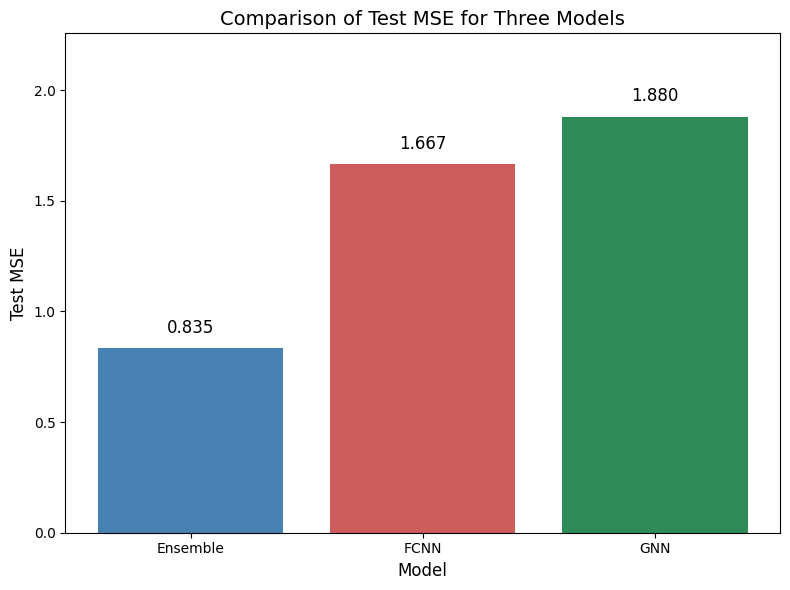

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Final Test MSE values from your experiments
model_names = ['Ensemble', 'FCNN', 'GNN']
test_mse_values = [0.8349, 1.6665, 1.88]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, test_mse_values, color=['steelblue', 'indianred', 'seagreen'])

plt.xlabel("Model", fontsize=12)
plt.ylabel("Test MSE", fontsize=12)
plt.title("Comparison of Test MSE for Three Models", fontsize=14)
plt.ylim(0, max(test_mse_values) * 1.2)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.3f}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

